# cadCAD Tutorials: The Robot and the Marbles, Networks Addition
In [Part 2](https://github.com/BlockScience/SimCAD-Tutorials/blob/master/demos/robot-marbles-part-2/robot-marbles-part-2.ipynb) we introduced the 'language' in which a system must be described in order for it to be interpretable by cadCAD and some of the basic concepts of the library:
* State Variables
* Timestep
* Policies
* State Update Functions
* Partial State Update Blocks
* Simulation Configuration Parameters

In the previous example, we observed how two robotic arms acting in parallel could result in counterintuitive system level behavior despite the simplicity of the individual robotic arm policies. 
In this notebook we'll introduce the concept of networks. This done by extending from two boxes of marbles to *n* boxes which are the nodes in our network. Furthermore, there are are going to be arms between some of the boxes but not others forming a network where the arms are the edges.

__The robot and the marbles__  
* Picture a set of n boxes (`balls`) with an integer number of marbles in each;  a network of robotic arms is capable of taking a marble from their one of their boxes and dropping it into the other one.
* Each robotic arm in the network only controls 2 boxes and they act by moving a marble from one box to the other.
* Each robotic arm is programmed to take one marble at a time from the box containing the largest number of marbles and drop it in the other box. It repeats that process until the boxes contain an equal number of marbles.
* For the purposes of our analysis of this system, suppose we are only interested in monitoring the number of marbles in only their two boxes.

In [1]:
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD.configuration import Configuration
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(97081340)
import pandas as pd
%matplotlib inline

T = 100 #iterations in our simulation
n=3 #number of boxes in our network
m= 2 #for barabasi graph type number of edges is (n-2)*m

G = nx.DiGraph()
G.add_edges_from([(1,0), (1,2)])

In [2]:
for node in G.nodes:
    rv = np.random.randint(1,25)
    G.nodes[node]['marbles'] = rv

In [3]:
# this time lets make three kinds of robots
def greedy_robot(src_balls, dst_balls):
    #robot wishes to accumlate balls at its source
    #takes half of its neighbors balls
    if src_balls < dst_balls:
        delta = -np.floor(dst_balls/2)
    else:
        delta = 0
    return delta

def fair_robot(src_balls, dst_balls):
    #robot follows the simple balancing rule
    delta = np.sign(src_balls-dst_balls)
    return delta


def giving_robot(src_balls, dst_balls):
    #robot wishes to gice away balls one at a time
    if src_balls > 0:
        delta = 1
    else:
        delta = 0
    return delta

#in the previous version the robots were assigned to the edges
#moving towards an agent based model formulation we assign the stratgies
#instead to the nodes
robot_strategies = [greedy_robot, fair_robot, giving_robot]
robot_colors = ['r', 'b', 'g']
# robot_strategies = [greedy_robot]
# robot_colors = ['r']

for edge in G.edges:
    nstrats = len(robot_strategies)
    rv  = np.random.randint(0,nstrats)
    G.edges[edge]['strat'] = robot_strategies[rv]
    G.edges[edge]['color'] = robot_colors[rv]    

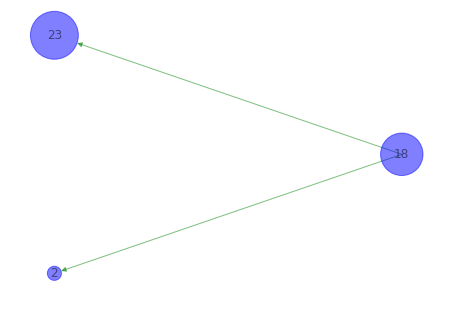

In [4]:

def draw_network(network, size_attr='marbles', labels_attr='marbles', scale=100, highlight_last=True, _pos=None):    
    colors = ['b']*(len(network.nodes))
    if highlight_last:
        colors[-1] = 'g'
    if _pos == None:
        _pos = nx.kamada_kawai_layout(network)
    nx.draw(network, 
            node_size=np.array(list(nx.get_node_attributes(network,size_attr).values()))*scale,
            labels=nx.get_node_attributes(network,labels_attr),
            node_color = colors,
            alpha = 0.5,
            pos = _pos,
            edge_color = list(nx.get_edge_attributes(network,'color').values())
    )

draw_network(G, highlight_last=False)    

In [5]:
initial_conditions = {'network':G}

In [6]:
#input the deltas along the edges and update the boxes
#mechanism: edge by node dimensional operator
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# We make the state update functions less "intelligent",
# ie. they simply add the number of marbles specified in _input 
# (which, per the policy function definition, may be negative)

def robots_policy(params, step, sL, s):
    graph = s['network']
    deltas = []
    for e in graph.edges:
        src = e[0]
        src_marbles = graph.nodes[src]['marbles']
        dst = e[1]
        dst_marbles = graph.nodes[dst]['marbles']
        #transfer balls according to specific robot strat
        strat = graph.edges[e]['strat']
        deltas.append(strat(src_marbles,dst_marbles))
    return {'deltas': deltas}
    

def move_robots(graph, deltas):
    for i,e in enumerate(graph.edges):
        src = e[0]
        dst = e[1]
        delta = deltas[i]
        if (graph.nodes[src]['marbles'] >= delta) and (graph.nodes[dst]['marbles'] >= -delta):
            graph.nodes[src]['marbles'] -= delta
            graph.nodes[dst]['marbles'] += delta

def add_box_policy(params, step, sL, s):
    graph = s['network']
    node = len(graph.nodes)
    neighbors = list(np.random.choice(graph.nodes,2,replace=False))
    edges = [(node,n) for n in neighbors]
    marbles = np.random.randint(1,25)
    rv  = np.random.randint(0,len(robot_strategies))

    return {'node_id': node, 
            'edges': edges, 
            'marbles': marbles, 
            'strategy_id': rv }

            
def add_box(graph, _node_id, _edges, _marbles, _strategy_id):
    graph.add_edges_from(_edges, strat=robot_strategies[_strategy_id], color=robot_colors[_strategy_id])
    graph.nodes[_node_id]['marbles'] = _marbles


def update_network(params, step, sL, s, _input):
    graph = s['network']
    move_robots(graph, _input['deltas'])    
    add_box(graph, _input['node_id'], _input['edges'], _input['marbles'], _input['strategy_id'])
    key = 'network'
    value = graph
    return (key, value)
    

In [7]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# In the Partial State Update Blocks, the user specifies if state update functions will be run in series or in parallel
partial_state_update_blocks = [
    { 
        'policies': { # The following policy functions will be evaluated and their returns will be passed to the state update functions
            'p1': robots_policy,
            'p2': add_box_policy
        },
        'variables': { # The following state variables will be updated simultaneously
            'a': update_network
        }
    }
]

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# Settings of general simulation parameters, unrelated to the system itself
# `T` is a range with the number of discrete units of time the simulation will run for;
# `N` is the number of times the simulation will be run (Monte Carlo runs)
# In this example, we'll run the simulation once (N=1) and its duration will be of 10 timesteps
# We'll cover the `M` key in a future article. For now, let's leave it empty
simulation_parameters = {
    'T': range(T),
    'N': 1,
    'M': {}
}

In [9]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The configurations above are then packaged into a `Configuration` object
config = Configuration(initial_state=initial_conditions, #dict containing variable names and initial values
                       partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
                       sim_config=simulation_parameters #dict containing simulation parameters
                      )

In [10]:
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result, tensor = executor.main() # The `main()` method returns a tuple; its first elements contains the raw results

single_proc: [<cadCAD.configuration.Configuration object at 0x10cf50a58>]


In [11]:
df = pd.DataFrame(raw_result)

In [12]:
df

,network,run,substep,timestep
0,"(1, 0, 2)",1,0,0
1,"(1, 0, 2, 3)",1,1,1
2,"(1, 0, 2, 3, 4)",1,1,2
3,"(1, 0, 2, 3, 4, 5)",1,1,3
4,"(1, 0, 2, 3, 4, 5, 6)",1,1,4
5,"(1, 0, 2, 3, 4, 5, 6, 7)",1,1,5
6,"(1, 0, 2, 3, 4, 5, 6, 7, 8)",1,1,6
7,"(1, 0, 2, 3, 4, 5, 6, 7, 8, 9)",1,1,7
8,"(1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10)",1,1,8
9,"(1, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",1,1,9


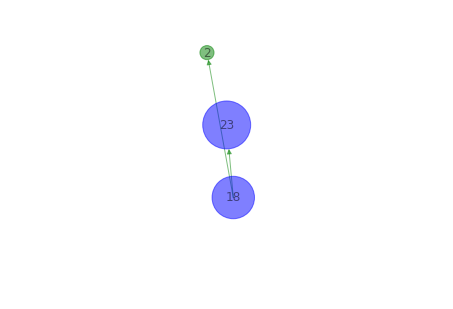

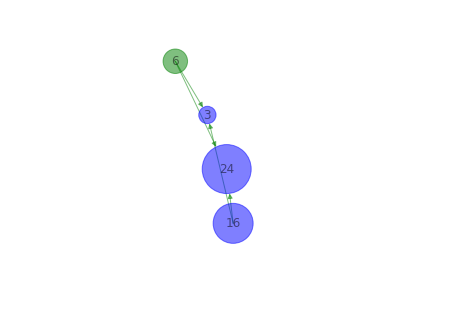

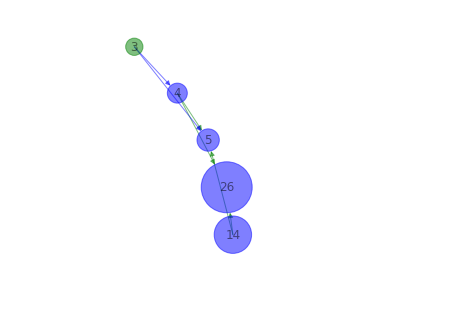

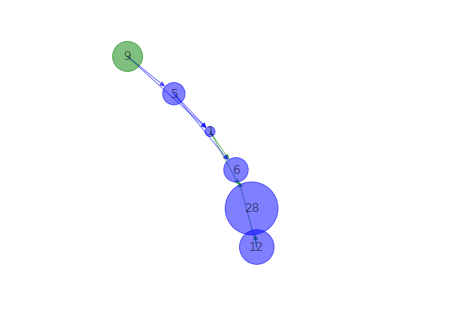

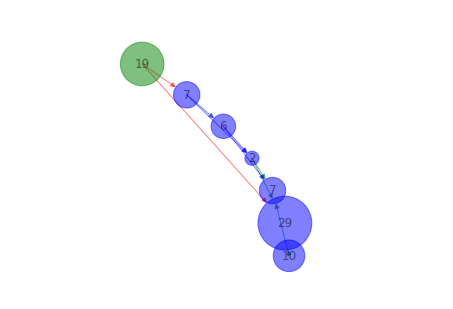

.....


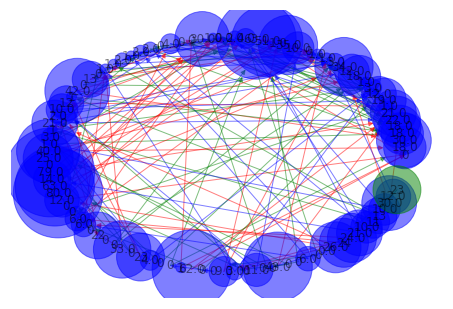

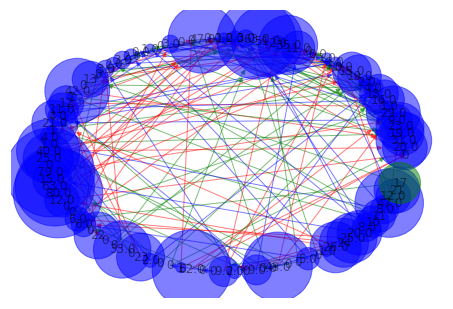

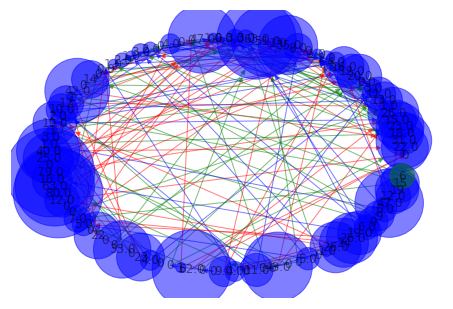

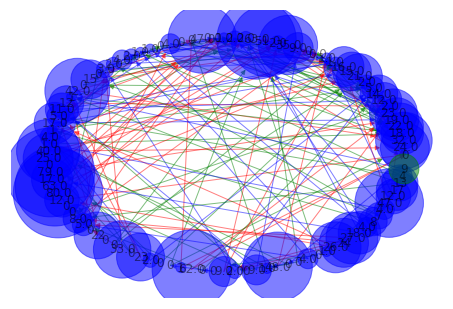

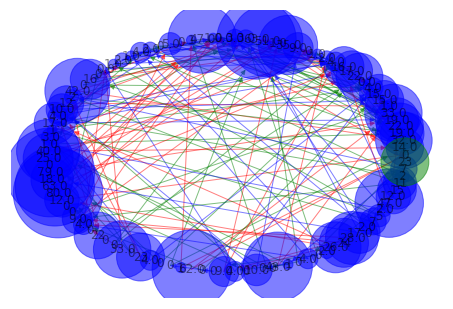

In [13]:
final_layout = nx.circular_layout(df['network'].iloc[-1])

for n in df['network'].head():
    draw_network(n, _pos=final_layout)
    plt.show()
print('.....')
for n in df['network'].tail():
    draw_network(n, _pos=final_layout)
    plt.show()    

In [14]:
def pad(vec, length, fill=True):
    res = vec.copy()
    pad = np.nan
    if fill:
        pad = 0
    res.extend([pad]*(length-len(res)))
    return res

def make2D(data, fill=False):
    maxL = data.apply(len).max()
    res = data.apply(lambda x: pad(x,maxL,fill))
    return list(res)

def plot_attribute(x, graph_series, attr):
    attr_series = graph_series.apply(lambda x: list(nx.get_node_attributes(x,attr).values()))
    plottable = make2D(attr_series)
    plt.plot(x, plottable);

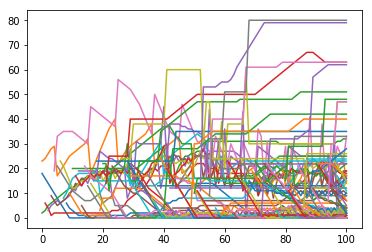

In [15]:
plot_attribute(df.timestep, df.network, 'marbles')

In [16]:
make2D('network',pd.DataFrame(df.network.apply(lambda x: list(nx.get_node_attributes(x,'marbles').values()))))

AttributeError: 'str' object has no attribute 'apply'

In [ ]:
list(make2D('network',pd.DataFrame(df.network.apply(lambda x: list(nx.get_node_attributes(x,'marbles').values())))))

In [ ]:
df['marbles'] = list(make2D('network',pd.DataFrame(df.network.apply(lambda x: list(nx.get_node_attributes(x,'marbles').values())))))
#make2D('network',pd.DataFrame(df.network.apply(lambda x: list(nx.get_node_attributes(x,'marbles').values()))))

In [ ]:
df

In [ ]:
plt.plot(df.timestep, list(make2D('network',pd.DataFrame(df.network.apply(lambda x: list(nx.get_node_attributes(x,'marbles').values()))))));

In [ ]:
plt.plot(df.timestep.values, balls_list)
plt.xlabel('iteration')
plt.ylabel('number of balls')
plt.title('balls in each box')
plt.legend(['Box #'+str(node) for node in range(n)], ncol = 2)

In [ ]:
end_state_balls = np.array([b for b in balls_list[-1]])
avg_balls = np.array([np.mean(b) for b in balls_list])

for node in G.nodes:
    G.nodes[node]['final_balls'] = end_state_balls[node]
    G.nodes[node]['avg_balls'] = avg_balls[node]

In [ ]:
cmap = plt.cm.jet
Nc = cmap.N
Ns = len(robot_strategies)
d = int(Nc/Ns)

k = len(G.edges)
strat_color = []
for e in G.edges:
    
    for i in range(Ns):
        if G.edges[e]['strat']==robot_strategies[i]:
            color = cmap(i*d)
            G.edges[e]['color'] = color
            strat_color = strat_color+[color]
            

In [ ]:
nx.draw_kamada_kawai(G, node_size=end_state_balls*scale, labels=nx.get_node_attributes(G,'final_balls'), edge_color=strat_color)
print(end_state_balls)

In [ ]:
rolling_avg_balls = np.zeros((T+1, n))
for t in range(T+1):
    for node in G.nodes:
        for tau in range(t):
            rolling_avg_balls[t,node] = (tau)/(tau+1)*rolling_avg_balls[t, node]+ 1/(tau+1)*balls_list[tau][node]

In [ ]:
plt.plot(range(len(rolling_avg_balls)),rolling_avg_balls)
plt.xlabel('iteration')
plt.ylabel('number of balls')
plt.title('time average balls in each box')
plt.legend(['Box #'+str(node) for node in range(n)], ncol = 2)

In [ ]:
for node in G.nodes:
    G.nodes[node]['avg_balls'] = int(10*(rolling_avg_balls[node][-1]))/10

nx.draw_kamada_kawai(G, node_size=avg_balls*scale, labels=nx.get_node_attributes(G,'avg_balls'))
print(end_state_balls)

In [ ]:
cmap = plt.cm.jet
Nc = cmap.N
Nt = len(simulation_parameters['T'])
dN = int(Nc/Nt)
cmaplist = [cmap(i*dN) for i in range(Nt)]

for t in simulation_parameters['T']:
    state = np.array([b for b in balls_list[t]])
    nx.draw_kamada_kawai(G, node_size=state*scale, alpha = .4/(t+1), node_color = cmaplist[t])